<a href="https://colab.research.google.com/github/Kyrylo-Bakumenko/NFL_Gamba_And_Power_Rankings/blob/main/Copy_of_NFL_Historical_Elo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
#@title Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numba import jit, njit
from scipy.stats import invgauss
%pylab inline

# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# season data: https://www.pro-football-reference.com/years/2019/games.htm
URL_BASE = 'https://www.pro-football-reference.com/years/'
URL_END = '/games.htm'

# quality of life
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [143]:
#@title Variables for notebook

SEASON_STARTED = False # use pickle?
START_YEAR = 1988 # first year in time frame
END_YEAR = 2021 # last year of time frame (non-inclusive)
SIM_COUNT = 200 # simulation count run for dynamic season prediction methods
MAX_GAIN = 32 # max elo awarded per win
SEASON_ADJ = 10 # max elo regressed from season placements
DELTA = 4 # factor by which early season games are more volatile
EPSILON = 1.2 # rate of decay for DELTA
ELO_STD_GAP = 400 # elo difference for 10x win chance

# methedology: optimize for accuracy using elo metrics,
# optimize profit with wager metrics

In [144]:
#@title User made functions

# return probability left wins in accordance to elo system
@njit
def win_prob(player_elo, opponent_elo):
  return 1/(1+10**((-player_elo+opponent_elo)/ELO_STD_GAP))
@njit
# return new elo for player
def elo_change(player_elo, opponent_elo, result, DELTA=1):
  player_win_prob = win_prob(player_elo, opponent_elo)
  return player_elo + (MAX_GAIN*DELTA) * (result-player_win_prob)

# generates list of season names
def get_season_names(start, end, step=1):
    seasons = ["Reference"]
    while start+step < end:
      start+=step
      seasons.append("'"+str(start)[-2:])
    seasons.append("'"+str(end)[-2:])
    return seasons

  ### Web scraping method

def scraped_season_list(START_YEAR, END_YEAR):
  seasons = []
  for year in range(START_YEAR, END_YEAR):
    try:
      df = pd.read_html(URL_BASE + str(year) + URL_END, header=0)[0]
      df.drop(columns=['Day', 'Week', 'Time', 'Unnamed: 5', 'Unnamed: 7', 'YdsW', 'TOW', 'YdsL', 'TOL'], inplace=True)
      df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
      df.dropna(inplace=True)
      df.set_index('Date', inplace=True)
      seasons.append(df)
    except:
      print(f'Failed at year: {year}')
      break
  return seasons

### Deprecated file method
def create_season_list_by_years(START_YEAR, END_YEAR):
  seasons = []
  for i in range(START_YEAR, END_YEAR):
    try:
      seasons.append(pd.read_excel("/content/NFL_Season_Data.xlsx", sheet_name=str(i), header=0, usecols="B:F", index_col=0))
    except:
      break
  return seasons
###

def list_rename_dropna(seasons):
  for cur_season in seasons:
    # rename because we will check for draws
    cur_season.rename(columns={"Winner/tie": "Left", "Loser/tie": "Right"}, inplace=True)
    # remove nan's (artifacts from website)
    cur_season.dropna(inplace=True)
    # bridge name changes by using consistent abbreviations
    cur_season["Left"]=cur_season["Left"].map(name_to_abbr).values
    cur_season["Right"]=cur_season["Right"].map(name_to_abbr).values
  return seasons

### set up predict method ###
# 256 games in regular season pre 2021
def predict_season_standings_static(Elo, cur_season):
  pred_table = pd.DataFrame(teams)
  pred_table["Wins"]=0
  pred_table.rename(columns={0: "Team"}, inplace=True)
  pred_table.set_index("Team", inplace=True)
  sim_table = pred_table
  for sim in range(SIM_COUNT):
    pred_table["Wins"]=0
    for i in range(256):
        # determine if left or right won, check scores
        #   0     1     2    3
        # Left	Right	Pts	Pts.1
        left = cur_season.iloc[i, 0]
        right = cur_season.iloc[i, 1]
        # win_prob is the probability the "left" player wins.
        # If the random number simulated is less than win_prob,
        # this even is considered true, otherwise "right" wins.
        rand = np.random.uniform()
        if rand < win_prob(Elo[left], Elo[right]):
          # left wins
          pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+1

        elif rand > win_prob(Elo[left], Elo[right]):
          # right wins
          pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+1
        else:
          # draw
          pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+0.5
          pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+0.5
    sim_table = sim_table + pred_table
  sim_table = sim_table/SIM_COUNT
  return sim_table.rename(columns={"Wins": "Stat_Wins"})


### considers the elo change of its own predicted outcomes ###
def predict_season_standings_dynamic(Elo, cur_season):
  pred_table = pd.DataFrame(teams)
  pred_table["Wins"]=0
  pred_table.rename(columns={0: "Team"}, inplace=True)
  pred_table.set_index("Team", inplace=True)
  sim_table = pred_table
  for sim in range(SIM_COUNT):
    pred_table["Wins"]=0
    for i in range(256):
      # determine if left or right won, check scores
      #   0     1     2    3
      # Left	Right	Pts	Pts.1
      left = cur_season.iloc[i, 0]
      right = cur_season.iloc[i, 1]
      # win_prob is the probability the "left" player wins.
      # If the random number simulated is less than win_prob,
      # this even is considered true, otherwise "right" wins.
      rand = np.random.uniform()
      if rand < win_prob(Elo[left], Elo[right]):
        # left wins
        pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+1
        Elo.update({
            left: elo_change(Elo[left], Elo[right], 1),
            right: elo_change(Elo[right], Elo[left], 0)
        })

      elif rand > win_prob(Elo[left], Elo[right]):
        # right wins
        pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+1
        Elo.update({
            left: elo_change(Elo[left], Elo[right], 0),
            right: elo_change(Elo[right], Elo[left], 1)
        })
      else:
        # draw
        pred_table.loc[left, "Wins"] = pred_table.loc[left, "Wins"]+0.5
        pred_table.loc[right, "Wins"] = pred_table.loc[right, "Wins"]+0.5
        Elo.update({
          left: elo_change(Elo[left], Elo[right], 0.5),
          right: elo_change(Elo[right], Elo[left], 0.5)
        })
    # print(pred_table.max(axis = 0))
    sim_table = sim_table + pred_table
  sim_table = sim_table/SIM_COUNT
  return sim_table.rename(columns={"Wins": "Dyn_Wins"})

In [145]:
#@title Abbreviate teams, Create and Label seasons
# import team name and abbreviation data
teams_abbr = pd.read_excel("/content/drive/My Drive/NFL_Analysis_Data/NFL_Season_Data.xlsx", sheet_name="TeamsABBR", header=0)
teams_abbr=teams_abbr.set_index("Franchise")
teams_abbr=teams_abbr.rename(columns={"Commonly Used Abbreviations": "Abbr"})

# set aside list of abbreviations
teams = teams_abbr["Abbr"].drop_duplicates().values

# create name to abbreviation dictionary
name_to_abbr = teams_abbr.to_dict()
name_to_abbr = name_to_abbr["Abbr"]

# creates a list of every season of nfl games from start year (inclusive) to end year (non-inclusive)
seasons = scraped_season_list(START_YEAR, END_YEAR)

# does some reformating and na dropping
seasons = list_rename_dropna(seasons)

# if no elo rankings have been done, make 1000
if not SEASON_STARTED:
  Elo = dict(zip(teams, np.full(shape=teams.shape[0], fill_value=1000)))

In [146]:
#@title Calculate Elo over range and save in Pickle
Elo
Elo_historical = []

# store zeros array
arr = np.zeros((32))

for cur_season in seasons:
  # create win total dictionary for yearly draft elo corrections
  season_wins = dict(zip(teams, arr))
  # variable growth rates for teams based off volatility
  DELTA_copy = DELTA # factor by which early season games are more volatile
  for i in range(len(cur_season)):
    if (i == 0) or (i % 16==0):
      Elo_historical.append(pd.Series(Elo))
    # determine if left or right won, check scores
    #   0     1     2    3
    # Left	Right	Pts	Pts.1
    left = cur_season.iloc[i, 0]
    right = cur_season.iloc[i, 1]
    if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
      # left wins
      try:
        Elo.update({
            left: elo_change(Elo[left], Elo[right], 1, DELTA_copy),
            right: elo_change(Elo[right], Elo[left], 0, DELTA_copy)
        })
        # update win totals
        season_wins[left] += 1
      except:
        print("Failed: ", left, right, "Season: ", cur_season.head(5), "Date: ", cur_season.index.values[i])
    elif cur_season.iloc[i, 2] < cur_season.iloc[i, 3]:
      # right wins
      Elo.update({
          left: elo_change(Elo[left], Elo[right], 0, DELTA_copy),
          right: elo_change(Elo[right], Elo[left], 1, DELTA_copy)
      })
      # update win totals
      season_wins[right] += 1
    else:
      # draw
      Elo.update({
          left: elo_change(Elo[left], Elo[right], 0.5, DELTA_copy),
          right: elo_change(Elo[right], Elo[left], 0.5, DELTA_copy)
      })
      # update win totals
      season_wins[left] += 0.5
      season_wins[right] += 0.5
    # update variables
    if DELTA_copy != 1:
      DELTA_copy = max(DELTA_copy/EPSILON, 1)
  # do draft day adjustments
  season_wins = sorted(season_wins.items(), key = lambda kv: kv[1])
  count = len(Elo)/2
  factor = SEASON_ADJ/count
  for entry in season_wins:
    team = entry[0]
    if team in Elo and Elo[team]!=1000:
      Elo.update({
          team: Elo[team]+count*factor
      })
      count -= 1

# just pickle it lmao
pickle.dump(Elo, open("elo.p", "wb" ))

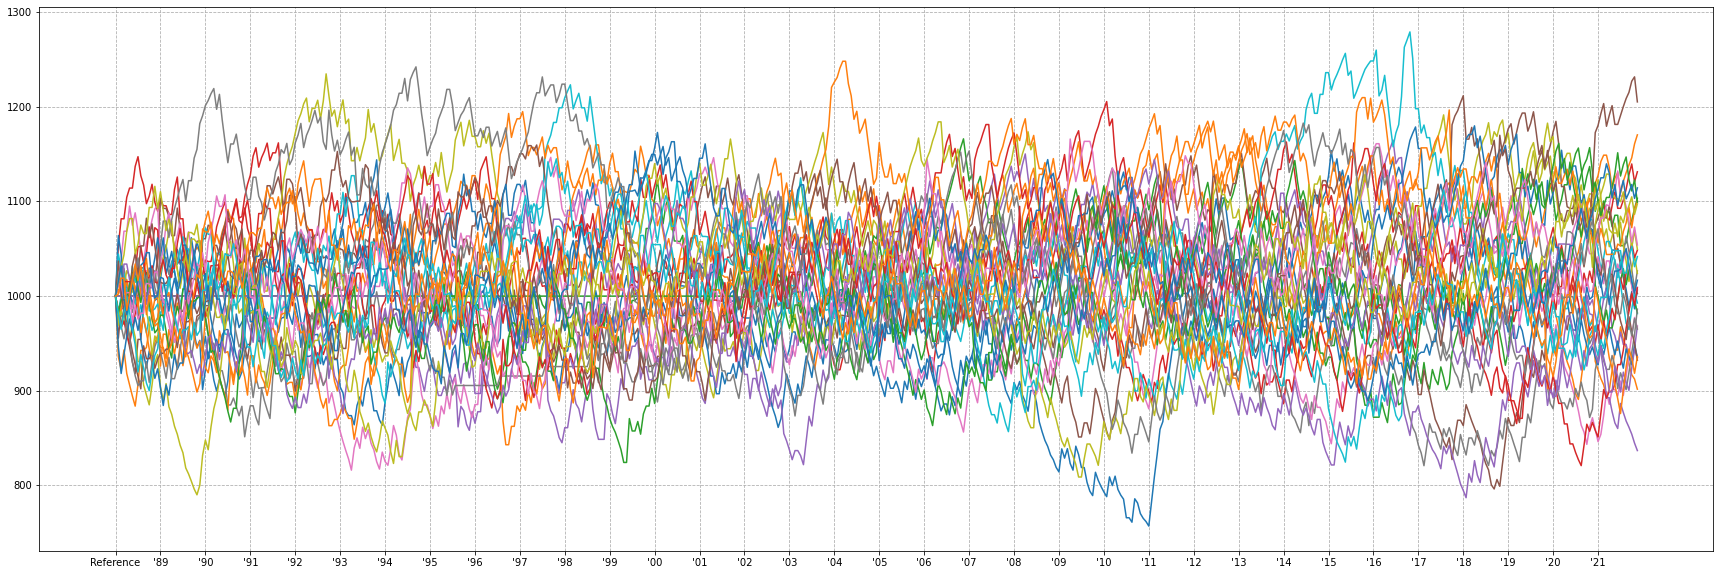

In [147]:
#@title Graph Elo data
# graph that juicy data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(30,10))

ax.plot(Elo_historical)
ax.minorticks_off()
plt.xticks(range(0, len(Elo_historical)+1, int(len(Elo_historical)/(END_YEAR-START_YEAR))),
              # get_season_names(START_YEAR, END_YEAR))
              labels=get_season_names(START_YEAR, END_YEAR))

ax.grid(linestyle='--')
# plt.legend(handles=[teams])

plt.show()

NYJ


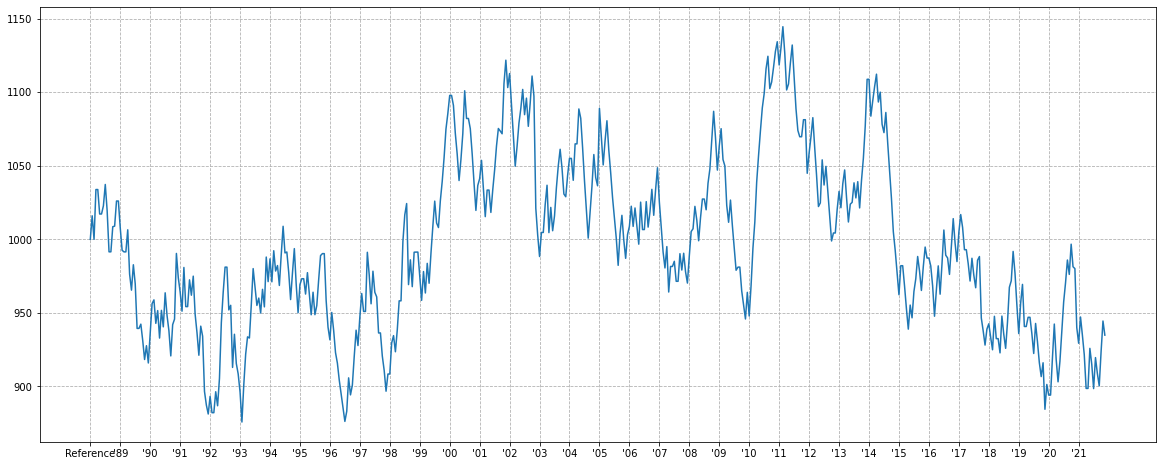

In [148]:
#@title Single team elo tracker - Optional
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,8))

# acr = input("Enter team ABRV: ")
acr = "NYJ"
print(acr)
ax.plot(pd.DataFrame(Elo_historical)[acr])
ax.minorticks_off()
plt.xticks(range(0, len(Elo_historical)+1, int(len(Elo_historical)/(END_YEAR-START_YEAR))),
              # get_season_names(START_YEAR, END_YEAR))
              labels=get_season_names(START_YEAR, END_YEAR))

ax.grid(linestyle='--')
# plt.legend(handles=[teams])

plt.show()

In [149]:
#@title Predict wins for 2020 season

# predict season standings with both methods, then merge into one DataFrame
static_wins = predict_season_standings_static(pickle.load(open("elo.p", "rb" )), seasons[len(seasons)-1])
dynamic_wins = predict_season_standings_dynamic(pickle.load(open("elo.p", "rb" )), seasons[len(seasons)-1])
pred_wins = pd.concat([static_wins, dynamic_wins], axis=1)

# scale win totals because something is seriously wrong
pred_wins = pred_wins*(256/pred_wins.sum()) # ????????

# pred_wins.sum() # it is 256 as expected, the hack fix above worked

pred_wins # print predicted wins for 2020 season

,Stat_Wins,Dyn_Wins
Team,,
ARI,7.79602,9.32836
ATL,4.98010,5.39801
BAL,10.47264,2.66667
BUF,9.60199,13.43284
CAR,7.04478,14.18408
CHI,8.26866,12.16418
CIN,6.94030,2.36318
CLE,8.21393,13.38806
DAL,8.87065,10.63184


In [150]:
#@title Import and Manage target season odds and games
# import moneyline betting data for 2020-21 season
game_bets = pd.read_excel("/content/drive/My Drive/NFL_Analysis_Data/NFL_Odds_2020-21.xlsx", sheet_name="Sheet1", header=0, usecols="D, I, L")#, index_col=0)

# convert ML into effective odds bookies are estimating
game_bets["Bookies Odds"] = 0

for row in range(game_bets["ML"].size):
  ML = game_bets["ML"][row]
  if ML > 0: # positive - udnerdog
    game_bets.iloc[row, 3] = 100/(ML+100)
  else: # negative - favorite
    game_bets.iloc[row, 3] = abs(ML)/(abs(ML)+100)

# prepare target gamble season games
tt_season = scraped_season_list(START_YEAR=2020, END_YEAR=2021)
tt_season = list_rename_dropna(tt_season)[0]
game_bets.tail(25);

In [165]:
#@title Wager Methods

### Returns with Kelly/Shannon/Thorp Entropy Bets ###
def bet_prop(prob_win):
  return min(2*np.power(1-prob_win, 1-prob_win)*np.power(prob_win, prob_win)-1, 0.1)
def bet_prop_rand(prob_win):
  return min(2*np.power(1-prob_win, 1-prob_win)*np.power(prob_win, prob_win)-1, 0.1)*np.random.normal(loc=1)
# convert into NNT's formula (double or bust payout)
@njit
def NNT_convert(bookies_odds, our_odds):
  return min(min((our_odds/(2*bookies_odds)), 0.5), our_odds<0.5)
### Simple approach because KSP has too many issues with above implementation ###
# 3x factor range is 2sigma
# theory: if factor is >50% of book, there is an annacounted for event e.g. injury
def bet_prop_simple(bookies_odds, our_odds):
  return 2*(invgauss.cdf(min(our_odds/bookies_odds, 3), mu=30)-0.5)

In [166]:
#@title Bet related user created functions
def find_index_of_team_game(ABR, matches_played, game_bets):
  i=0
  idx = game_bets.loc[game_bets.Team==ABR].index[0]
  while idx < 2*matches_played:
    i+=1
    idx = game_bets.loc[game_bets.Team==ABR].index[i]
  return idx

### considers the elo change of its own predicted outcomes before predicting every bet ###
def predict_season_standings_dynamic_bets(Elo, cur_season, game_bets):
  bets_taken_table = cur_season.iloc[0:0]
  bets_taken_table["Winner"] = "n/a"
  bets_taken_table["Bookies Odds"] = 0
  bets_taken_table["Our Odds"] = 0
  bets_taken_table["Correct"] = True

  for i in range(len(cur_season)): # every game in cur_season
    # determine if left or right won, check scores
    #   0     1     2    3
    # Left	Right	Pts	Pts.1
    left = cur_season.iloc[i, 0]
    right = cur_season.iloc[i, 1]

    # odds left wins according to elo model
    left_win_prob = win_prob(Elo[left], Elo[right])
    # odds right wins according to elo model
    right_win_prob = 1-left_win_prob

    # index of left team
    try:
      idx = find_index_of_team_game(left, i, game_bets)
    except:
      pass # print("left", left, i) error
    # find bookies odds
    BO = game_bets.loc[idx, "Bookies Odds"]
    # if model winchance is greater than bookies, add to bets_taken_table
    if left_win_prob > BO:

      row = cur_season.iloc[i]
      if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
        row.loc["Winner"] = left
      else:
        row.loc["Winner"] = right
      row.loc["Bookies Odds"] = game_bets.loc[idx, "Bookies Odds"]
      row.loc["Our Odds"] = left_win_prob
      row.loc["Correct"] = (left==row.loc["Winner"])
      bets_taken_table=bets_taken_table.append(row)
    
    #repeat above for right team

    # index of left team
    #idx = find_index_of_team_game(right, i, game_bets)
    try:
      idx = find_index_of_team_game(right, i, game_bets)
    except:
      pass # print("right", right, i) error
    # find bookies odds
    BO = game_bets.loc[idx, "Bookies Odds"]
    # if model winchance is greater than bookies, add to bets_taken_table
    if right_win_prob > BO:

      row = cur_season.iloc[i]
      if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
        row.loc["Winner"] = left
      else:
        row.loc["Winner"] = right
      row.loc["Bookies Odds"] = game_bets.loc[idx, "Bookies Odds"]
      row.loc["Our Odds"] = right_win_prob
      row.loc["Correct"] = (right==row.loc["Winner"])
      bets_taken_table=bets_taken_table.append(row)
    
    # print("Ours:\t", right_win_prob,
    #      '\nTheirs:\t', BO)

    # determine if left or right won, check scores
    #   0     1     2    3
    # Left	Right	Pts	Pts.1

    if cur_season.iloc[i, 2] > cur_season.iloc[i, 3]:
      # left wins
      Elo.update({
          left: elo_change(Elo[left], Elo[right], 1),
          right: elo_change(Elo[right], Elo[left], 0)
      })

    elif cur_season.iloc[i, 2] < cur_season.iloc[i, 3]:
      # right wins
      Elo.update({
          left: elo_change(Elo[left], Elo[right], 0),
          right: elo_change(Elo[right], Elo[left], 1)
      })
    else:
      # draw
      Elo.update({
        left: elo_change(Elo[left], Elo[right], 0.5),
        right: elo_change(Elo[right], Elo[left], 0.5)
      })
  return bets_taken_table

# find income
def method_returns(bets_taken_table):
  bet_size = 1
  method_profit = 0
  bets_taken_table['Profit'] = 0
  ### ... 'Bookies Odds' 'Our Odds' 'Correct' 'Profit'
  ### ...         5           6         7         8
  for game_num in range(len(bets_taken_table)):
    BO = bets_taken_table.iloc[game_num, 5] # bookies odds
    OO = bets_taken_table.iloc[game_num, 6] # our odds
    if OO > BO:
      bet = bet_size*bet_prop_simple(BO, OO) # bet amount
      profit = bet*(2*bets_taken_table.iloc[game_num, 7]-1) # profit/loss
      method_profit += profit
      bets_taken_table.iloc[game_num, 8] = profit
  total_wagered = bet_size*len(bets_taken_table) # total $ amount wagered
  profit_per_wager = method_profit/total_wagered # Profit per game of 2020 season per dollar wagered
  return (profit_per_wager, method_profit)

In [167]:
#@title Create bet table and print key stats
# create table with bets
bets_taken_table = predict_season_standings_dynamic_bets(pickle.load(open("elo.p", "rb" )), tt_season, game_bets)

# get some quick performance stats
num_correct = len(bets_taken_table[bets_taken_table["Correct"]])
num_false = len(bets_taken_table[bets_taken_table["Correct"]==False])
print("Correct Predictions Identified:\t", num_correct,
      "\nMistaken Predictions:\t\t", num_false,
      "\nAccuracy:\t\t\t", f"{round(num_correct*100/(num_correct+num_false), 3)}%\n")

# get returns
return_per_game, return_from_season = method_returns(bets_taken_table)

# print some metrics
print(f'Return from 2020 season:\t${round(return_from_season, 3)}')
print(f'Profit/game/$ from 2020 season: ${round(return_per_game, 4)}')

# observe bets
bets_taken_table.tail(25)

Correct Predictions Identified:	 135 
Mistaken Predictions:		 121 
Accuracy:			 52.734%

Return from 2020 season:	$-1.532
Profit/game/$ from 2020 season: $-0.006


,Left,Right,Pts,Pts.1,Winner,Bookies Odds,Our Odds,Correct,Profit
Date,,,,,,,,,
2021-01-03,NYG,DAL,23,19,NYG,0.48780,0.58073,True,-0.25708
2021-01-03,NE,NYJ,28,14,NE,0.62963,0.72371,True,-0.27453
2021-01-03,BUF,MIA,56,26,BUF,0.40816,0.68316,True,-0.09148
2021-01-03,MIN,DET,37,35,MIN,0.40000,0.44280,False,0.29327
2021-01-03,BAL,CIN,38,3,BAL,0.13333,0.38970,False,-0.15438
2021-01-03,CLE,PIT,24,22,CLE,0.33333,0.50689,True,-0.13723
2021-01-03,IND,JAX,28,14,IND,0.25641,0.83771,True,0.16492
2021-01-03,LAR,ARI,18,7,ARI,0.55556,0.58907,False,0.31478
2021-01-03,SEA,SF,26,23,SEA,0.26316,0.27668,False,0.31901


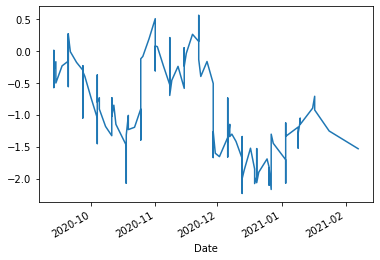

In [168]:
#@title Create and graph cumsum metric
# create cumsum metric
bets_taken_table['Sum'] = bets_taken_table.Profit.cumsum()

# plot cumsum
bets_taken_table['Sum'].dropna().plot();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2502b39b50>]],
      dtype=object)

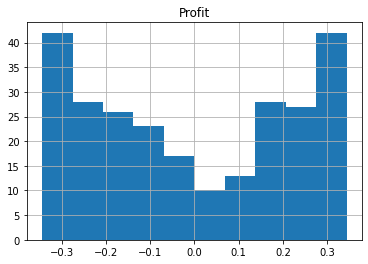

In [169]:
#@title More Metrics

d = bets_taken_table[['Correct','Profit']]
d.set_index('Correct', inplace=True)
d.hist(bins=10)

In [170]:
df = bets_taken_table[['Profit']]
df['Edge'] = bets_taken_table['Our Odds']/bets_taken_table['Bookies Odds']
# df.set_index('Edge', inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Profit,Edge
Date,,
2020-09-13,-0.17586,1.40404
2020-09-13,-0.16725,1.42911
2020-09-13,-0.17769,1.39880
2020-09-13,-0.05389,1.81354
2020-09-13,0.31638,1.05692
...,...,...
2021-01-16,0.25439,1.19696
2021-01-17,0.18637,1.37413
2021-01-17,-0.21434,1.29797


<Figure size 432x288 with 0 Axes>

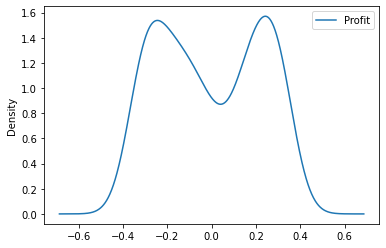

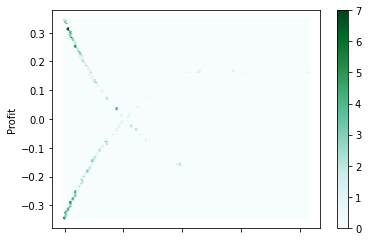

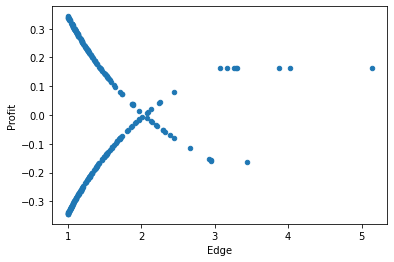

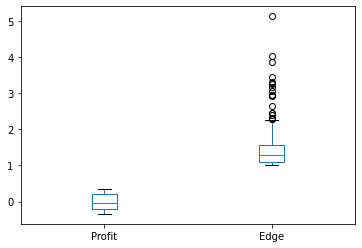

In [171]:

# df.hist(bins=20)
plt.figure();

df.plot.density(x='Edge', y='Profit')
df.plot.hexbin(x='Edge', y='Profit')
df.plot.scatter(x='Edge', y='Profit')
df.plot.box()